In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import quad
from scipy.interpolate import interp1d 
import statsmodels.api as sm 
import warnings

In [2]:
stop_correct_BHV_CS_df=pd.read_csv('stop_correct_BHV_CS.csv')
stop_wrong_BHV_WS_df=pd.read_csv('stop_wrong_BHV_WS.csv')
nostop_BHV_GO_df=pd.read_csv('nostop_BHV_GO.csv')

The behavioral analysis we are about to conduct is based on the race model as presented in the paper by Candelori et al., so we will calculate a P(response) curve based on the SSDs to model the response with respect to the SSD, then we will integrate the P(response) function over the distribution of the Go trial and subtract the SSD in order to calculate the SSRT, a variable that describes the speed of the inibitory processes that stop movement.

In order to produce a suitable P(Responde|SSD) equation we can use two methods :
-one is a simple algebric method that estimates the parameters in the general equation of a sigmoid curve from the raw data by interpolation
-the other method looks to minimize the inverse of the log of the maximum likelihood binomial equation
We will attempt both

In [3]:
warnings.filterwarnings('ignore')
#Let's define the data by picking the two features that interest us and combining it across the datasets involving the correct stop and the wrong stop
SSD_stop_correct=stop_correct_BHV_CS_df[['StopSignal(s)','TrialNumber']]
SSD_stop_wrong=stop_wrong_BHV_WS_df[['StopSignal(s)','TrialNumber']]
#Now we add the labels by adding an additional column to the DataFrame that describes the original DataFrame of the data 
SSD_stop_correct['Result']='CS'
SSD_stop_wrong['Result']='WS'
SSD_combined=pd.concat([SSD_stop_correct,SSD_stop_wrong],ignore_index=True)
SSD_combined_df=pd.DataFrame(SSD_combined)
SSD_combined_df['Result']=SSD_combined_df['Result'].map({"WS":1,"CS":0})
SSD_combined_df

,StopSignal(s),TrialNumber,Result
0,0.313467,19.0,0
1,0.413655,27.0,0
2,0.514048,31.0,0
3,0.313344,72.0,0
4,0.313467,90.0,0
...,...,...,...
189,0.514826,981.0,1
190,0.514540,991.0,1
191,0.514744,997.0,1
192,0.414065,999.0,1


In [4]:
#Let's define a sigmoid curve so we can have parameters to analyze later
def logistic(x,a,b):
    return 1/(1+np.exp(-(x-a)/b)) 
#Interpolation model, tries to minimize the absolute error I have decided to use bootstrapping (repated sampling with a random number of samples) in order to obtain a confidence intervall as the data is not exactly pristine
def fit_curvefit_bootstrap(df, ssd_col="StopSignal(s)", result_col="Result", n_boot=1000):
    x=df[ssd_col].values
    y=df[result_col].values 
#Initial fit with rough values of a and b, the a random number will be generated for a number of times equal to n_boot and the results will be plotted to determine the CI
    popt,_=curve_fit(logistic,x,y,p0=[np.median(x),50])
    a_hat,b_hat=popt
    #bootstrap con campionamento randomico
    boot_params=[]
    rng=np.random.default_rng()
    for _ in range(n_boot):
        idx=rng.choice(len(x), len(x), replace=True)
        xb,yb=x[idx],y[idx]
        try :
            popt_b,_=curve_fit(logistic, xb, yb, p0=[np.median(xb), 50],maxfev=2000)
            boot_params.append(popt_b)
        except:
            continue
    boot_params=np.array(boot_params) 
    return a_hat, b_hat, boot_params
#MLE (Maximum Likelihood Estimation) uses a likelihood equation based on the real data in order to plot the function that maps the best onto reality by maximizing the value of the equation
def fit_mle_bootstrap(df, ssd_col="StopSignal(s)", result_col="Result", n_boot=1000):
    x=df[ssd_col].values
    y=df[result_col].values
    X=sm.add_constant(x)
    model=sm.Logit(y,X)
    res=model.fit(disp=False)
    intercept, slope=res.params
    b_hat=1/slope
    a_hat=-intercept/slope 
    boot_params=[]
    rng=np.random.default_rng()
    for _ in range (n_boot):
        idx=rng.choice(len(x), len(x), replace=True)
        xb, yb=x[idx],y[idx]
        Xb=sm.add_constant(xb)
        try:
            res_b=sm.Logit(yb, Xb).fit(disp=False)
            intercept_b,slope_b=res_b.params
            b_b=1/slope_b
            a_b=-intercept_b/slope_b
            boot_params.append([a_b,b_b])
        except:
            continue
    boot_params=np.array(boot_params)

    return a_hat,b_hat,boot_params, res    
        
            

In [18]:
def plot_results(df, a_cf, b_cf, boots_cf, a_mle, b_mle, boots_mle,
                 ssd_col="StopSignal(s)", result_col="Result"):
    x = df[ssd_col].values
    y = df[result_col].values
    
    ssd_grid = np.linspace(df[ssd_col].min(), df[ssd_col].max(), 300)
    p_cf = logistic(ssd_grid, a_cf, b_cf)
    p_mle = logistic(ssd_grid, a_mle, b_mle)
    
    # CI bootstrap per curve_fit
    if len(boots_cf) > 0:
        preds_cf = [logistic(ssd_grid, a, b) for a, b in boots_cf]
        ci_low_cf = np.percentile(preds_cf, 2.5, axis=0)
        ci_high_cf = np.percentile(preds_cf, 97.5, axis=0)
    else:
        ci_low_cf, ci_high_cf = None, None
    
    # CI bootstrap per MLE
    if len(boots_mle) > 0:
        preds_mle = [logistic(ssd_grid, a, b) for a, b in boots_mle]
        ci_low_mle = np.percentile(preds_mle, 2.5, axis=0)
        ci_high_mle = np.percentile(preds_mle, 97.5, axis=0)
    else:
        ci_low_mle, ci_high_mle = None, None
    
    plt.figure(figsize=(9,6))
    
    # raw data
    plt.scatter(x, y, alpha=0.3, label="Raw trial (0=CS,1=WS)")
    
    # curve_fit + CI
    plt.plot(ssd_grid, p_cf, color="red", lw=2, label="Curve_fit")
    if ci_low_cf is not None:
        plt.fill_between(ssd_grid, ci_low_cf, ci_high_cf, color="red", alpha=0.2)
    
    # MLE + CI
    plt.plot(ssd_grid, p_mle, color="blue", lw=2, label="MLE")
    if ci_low_mle is not None:
        plt.fill_between(ssd_grid, ci_low_mle, ci_high_mle, color="blue", alpha=0.2)
    plt.xlabel("Stop Signal Delay (ms)")
    plt.ylabel("P(response)")
    plt.title("Curva psicometrica stimata con CI bootstrap")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

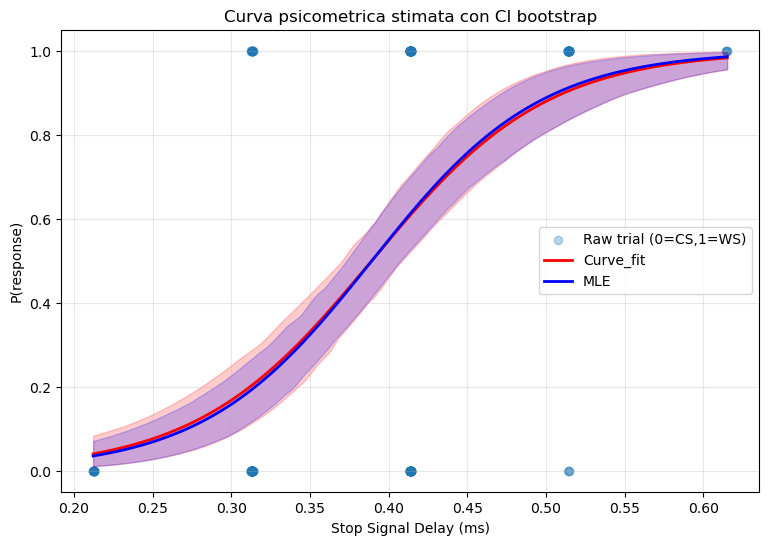

In [19]:
# supponiamo di avere un dataframe df con colonne:
# - "StopSignal(s)" = SSD
# - "Result" = 0 (CS) / 1 (WS)
# e un array con i tempi GO
go_rts =nostop_BHV_GO_df["MoveOnset(s)"] 

# fit interpolazione
a_cf, b_cf, boots_cf = fit_curvefit_bootstrap(SSD_combined_df, n_boot=200)

# fit MLE
a_mle, b_mle, boots_mle, res = fit_mle_bootstrap(SSD_combined_df, n_boot=200)
# plot finale
plot_results(SSD_combined_df, a_cf, b_cf, boots_cf, a_mle, b_mle, boots_mle)

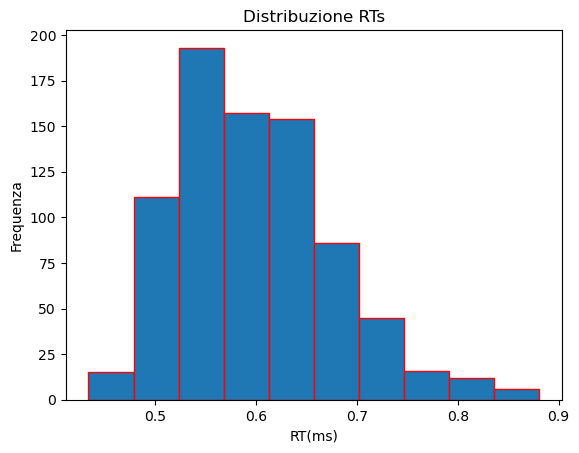

In [20]:
plt.hist(go_rts, bins=10, edgecolor='red')
plt.xlabel('RT(s)')
plt.ylabel('Frequenza')
plt.title('Distribuzione RTs')
plt.show()

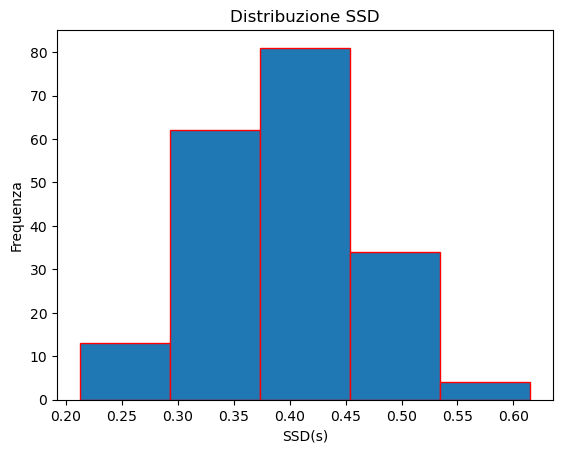

In [33]:
plt.hist(SSD_combined_df['StopSignal(s)'], bins=5
         , edgecolor='red')
plt.xlabel('SSD(s)')
plt.ylabel('Frequenza')
plt.title('Distribuzione SSD')
plt.show()

In [34]:
def compute_ssrt(x,y,df,n):
    x=np.array(x)
    y=np.array(y)
    x_half=np.interp(0.5,y,x)
    percentile_n=np.percentile(df.dropna(),n)
    ssrt=round(percentile_n-x_half, 4)
    
    return ssrt 

In [35]:
compute_ssrt(SSD_combined_df['StopSignal(s)'], logistic(SSD_combined_df['StopSignal(s)'], a_mle, b_mle), go_rts, 50)

0.201

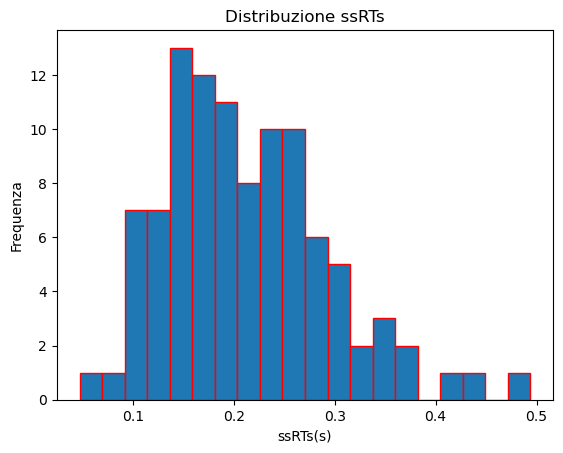

In [36]:
ssrt_distribution=[]
for n in range(101):
    ssrt=compute_ssrt(SSD_combined_df['StopSignal(s)'], logistic(SSD_combined_df['StopSignal(s)'], a_mle, b_mle), go_rts, n)
    ssrt_distribution.append(ssrt)
plt.hist(ssrt_distribution, bins=20
         , edgecolor='red')
plt.xlabel('ssRTs(s)')
plt.ylabel('Frequenza')
plt.title('Distribuzione ssRTs')
plt.show()
